In [ ]:
# Stable Baselines only supports tensorflow 1.x for now
%tensorflow_version 1.x
!apt-get install ffmpeg freeglut3-dev xvfb  # For visualization
!pip install stable-baselines[mpi]==2.10.0
!apt install swig cmake libopenmpi-dev zlib1g-dev

In [ ]:
import stable_baselines
stable_baselines.__version__

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



'2.10.0'

In [ ]:
from gridworldRNN import *
from gridworld2 import *
from random import random
from gym import Env
import gym
from gym import spaces

In [ ]:
from stable_baselines import PPO2
# check my gym enviroment
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.policies import MlpLstmPolicy

In [ ]:
from stable_baselines.common.vec_env import SubprocVecEnv
from stable_baselines.common import set_global_seeds, make_vec_env
from stable_baselines.common.evaluation import evaluate_policy
from stable_baselines.common.policies import *

In [ ]:
from stable_baselines.common.env_checker import check_env

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# sns test
sns.set_style("darkgrid")

In [ ]:
class CustomLSTMPolicy(LstmPolicy):
  """
  for the default LstmPolicy :
    n_lstm:(int) the number of LSTM cells (default = 256) the number of hidden neurons
    layers:([int]) The size of the Neural network before the LSTM layer  (if None, default to [64, 64])
    net_arch:(list) Specification of the actor-critic policy network architecture. Notation similar to the
        format described in mlp_extractor but with additional support for a 'lstm' entry in the shared network part.
  """
  def __init__(self, sess, ob_space, ac_space, n_env, n_steps, n_batch, layers=None, n_lstm=256, reuse=False, **_kwargs):
        super().__init__(sess, ob_space, ac_space, n_env, n_steps, n_batch, n_lstm, layers, reuse,
                         net_arch=[8, 'lstm', dict(vf=[64], pi=[64])],
                         layer_norm=True, feature_extraction="mlp", **_kwargs)

In [ ]:
# set the enviroment for model1

def set_enviroment_one(n_width, n_height,flag=True):
    
    if flag== False:
        env = GridWorldEnv(n_width =n_width,n_height=n_height,
                       u_size=40,
                      default_reward=-1,
                      default_type= 0 ,
                      max_episode_steps=100)
    else:
      # if it is True, here is POMDP
        env = GridWorldEnvNew(n_width =n_width,n_height=n_height,
                       u_size=40,
                      default_reward=-1,
                      default_type= 0,
                      max_episode_steps=100 )
 
    env.start= (2,2)
    env.end= (5,5)
    # set the special reward for end
    env.grids.set_reward(env.end[0], env.end[1],0)
    
    env.refresh_setting()
    check_env(env)
    return env
    

## 7*7 Grid in POMDP(Lstm)

In [ ]:
def test_render(env):
  
    start_time = time.time()
    for _ in range(1000):       
        #env.render()
    # take a random action
        a = env.action_space.sample()
        obs, reward, isdone, info = env.step(a)
        print("{0}, {1}, {2},{3}".format(obs, a, reward, isdone))
    end_time=time.time()
    print('render close')
    print("the process time is:", end_time-start_time)

### Evaluation part
#### evaluate the rewards of the model in 100 episodes

In [ ]:
# add evaluation module
def evaluate(model, num_episodes=100):
    """
    Evaluate a RL agent
    :param model: (BaseRLModel object) the RL Agent
    :param num_episodes: (int) number of episodes to evaluate it
    :return: (float) Mean reward for the last num_episodes
    """
    # This function will only work for a single Environment
    env = model.get_env()
    all_episode_rewards = []
    for i in range(num_episodes):
        episode_rewards = []
        done = False
        obs = env.reset()
        while not done:
            # _states are only useful when using LSTM policies
            action, _states = model.predict(obs)
            #print("without noise:", action)
            # here, action, rewards and dones are arrays
            obs, reward, done, info = env.step(action)
            episode_rewards.append(reward)

        all_episode_rewards.append(sum(episode_rewards))

    mean_episode_reward = np.mean(all_episode_rewards)
    #print("Mean reward:", mean_episode_reward, "Num episodes:", num_episodes)

    return mean_episode_reward

## draw the picture

In [ ]:
def reward_plot(reward):
  x=np.linspace(0, 1000*(len(reward)),len(reward),endpoint=True)
  plt.plot(x,reward,label='model1')

def reward_plot_two(reward1,reward2):
    x=np.linspace(0, 1000*(len(reward1)),len(reward1),endpoint=True)
    plt.plot(x,reward1,label='model1')
    plt.plot(x,reward2)

def reward_plot_all(rewards):
  n = len(rewards)
  x=np.linspace(0, 1000*(len(rewards[0])-1),len(rewards[0])-1,endpoint=True)
  for _ in range(n):
    plt.plot(x, rewards[_][1:])

# train the agent

In [ ]:
def train_agent(model):
  start_time = time.time()
  reward=[]
  for _ in range(10):
    model.learn(total_timesteps=1000)
    x = evaluate(model,num_episodes=100)
    reward.append(x)
  end_time = time.time()
  process_time =  end_time - start_time
  print("the process time is:", process_time)
  return reward, process_time

In [ ]:
def train_plot(model,num):

  rewards = []
  ts = 0
  for _ in range(num):
    r,t = train_agent(model)
    rewards+=r
    ts+=t
    print(rewards[-1])
 
  
  return rewards,ts



## test in MDP problem (7*7 Grids)

In [ ]:
## MDP problem for mlp(default parameters)
env_7_mlp_1 = set_enviroment_one(n_width=7, n_height=7,flag=False)
model_7_mlp_1 = PPO2('MlpPolicy',env_7_mlp_1,verbose=0)

In [ ]:
# MDP problem for mlp(same parameters of lstm)
env_7_mlp_2 = set_enviroment_one(n_width=7, n_height=7,flag=False)
model_7_mlp_2 = PPO2('MlpPolicy', env_7_mlp_2, nminibatches=1,
                 lam=0.95, gamma=0.99, noptepochs=4, ent_coef=.01,
                 learning_rate=lambda f: f * 2.5e-4, cliprange=lambda f: f * 0.1, verbose=0)

In [ ]:
# MDP problem for lstm 
# nminibatches, noptepoch, learning rate, cliprange

env_7_lstm = set_enviroment_one(n_width=7, n_height=7,flag=False)
model_7_lstm =  PPO2(CustomLSTMPolicy, env_7_lstm, nminibatches=1,
                 lam=0.95, gamma=0.99, noptepochs=4, ent_coef=.01,
                 learning_rate=lambda f: f * 2.5e-4, cliprange=lambda f: f * 0.1, verbose=0)

In [ ]:
reward_mlp_7_1,t_mlp_7_1= train_plot(model_7_mlp_1,num=3)

the process time is: 27.84242534637451
-8.96
the process time is: 13.144076347351074
-5.02
the process time is: 12.750109672546387
-5.02


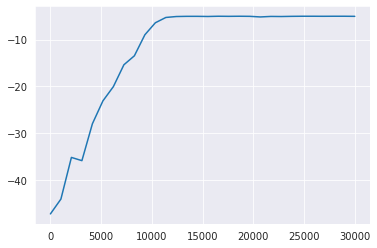

In [ ]:
reward_plot(reward_mlp_7_1)

In [ ]:
reward_mlp_7_2,t_mlp_7_2= train_plot(model_7_mlp_2,num=3)

the process time is: 38.58359694480896
-41.84
the process time is: 31.872554063796997
-19.99
the process time is: 17.5878963470459
-8.98


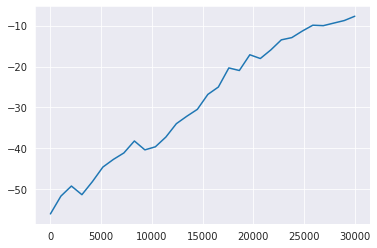

In [ ]:
reward_plot(reward_mlp_7_2)

In [ ]:
reward_lstm_7,t_lstm_7= train_plot(model_7_lstm,num=3)

the process time is: 86.64191341400146
-9.29
the process time is: 54.32578706741333
-7.25
the process time is: 52.82455372810364
-6.53


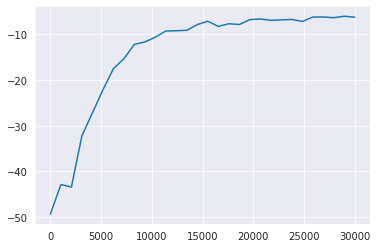

In [ ]:
reward_plot(reward_lstm_7)

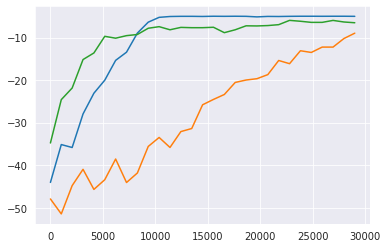

In [ ]:
# the compare in the MLP problem(7*7)
rewards_mdp_7 =[]
rewards_mdp_7.append(reward_mlp_7_1)
rewards_mdp_7.append(reward_mlp_7_2)
rewards_mdp_7.append(reward_lstm_7)
reward_plot_all(rewards_mdp_7)

## test in the original POMDP enviroment(7*7 Grids)

In [ ]:
from gridworld2 import *

In [ ]:
# mlp(default parameters) in pomdp
env0_7_mlp_1 = set_enviroment_one(n_width=7, n_height=7,flag=True)
model0_7_mlp_1 = PPO2('MlpPolicy',env0_7_mlp_1,verbose=0)

In [ ]:
# mlp(same parameters as lstm) in pomdp
env0_7_mlp_2 = set_enviroment_one(n_width=7, n_height=7,flag=True)
model0_7_mlp_2 = PPO2('MlpPolicy', env0_7_mlp_2, nminibatches=1,
                 lam=0.95, gamma=0.99, noptepochs=4, ent_coef=.01,
                 learning_rate=lambda f: f * 2.5e-4, cliprange=lambda f: f * 0.1, verbose=0)

In [ ]:
env0_7_lstm = set_enviroment_one(n_width=7, n_height=7,flag=True)
model0_7_lstm = PPO2(CustomLSTMPolicy, env0_7_lstm, nminibatches=1,
                 lam=0.95, gamma=0.99, noptepochs=4, ent_coef=.01,
                 learning_rate=lambda f: f * 2.5e-4, cliprange=lambda f: f * 0.1, verbose=0)

/usr/local/lib/python3.6/dist-packages/stable_baselines/common/policies.py:437: UserWarning: The new net_arch parameter overrides the deprecated layers parameter.
  warnings.warn("The new net_arch parameter overrides the deprecated layers parameter.")


In [ ]:
# mlp1(default parameters) works in POMDP
reward0_mlp_7_1, t0_mlp_7_1=train_plot(model0_7_mlp_1,num=5)

the process time is: 23.29283905029297
-8.49
the process time is: 16.000754356384277
-8.27
the process time is: 15.739299774169922
-7.71
the process time is: 15.556817293167114
-7.59
the process time is: 15.649059772491455
-7.26


the whole process time is: 86.23877024650574
the end reward is: -7.26


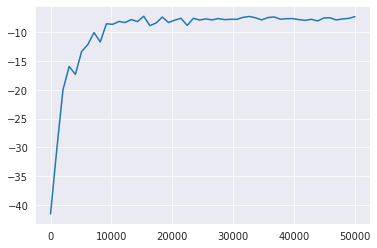

In [ ]:
print("the whole process time is:", t0_mlp_7_1)
print("the end reward is:", reward0_mlp_7_1[-1])
reward_plot(reward0_mlp_7_1)

In [ ]:
# mlp2(default parameters) works in POMDP
reward0_mlp_7_2, t0_mlp_7_2=train_plot(model0_7_mlp_2,num=5)

the process time is: 37.36467385292053
-26.95
the process time is: 20.821829319000244
-12.49
the process time is: 16.095935344696045
-9.03
the process time is: 14.437994718551636
-8.11
the process time is: 14.271602630615234
-8.43


the whole process time is: 102.99203586578369
the end reward is: -8.43


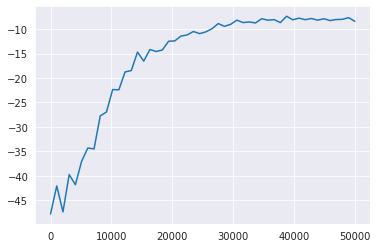

In [ ]:
print("the whole process time is:", t0_mlp_7_2)
print("the end reward is:", reward0_mlp_7_2[-1])
reward_plot(reward0_mlp_7_2)

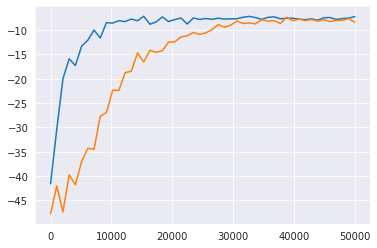

In [ ]:
# the compare between two different MlpPolicy
reward_plot_two(reward0_mlp_7_1,reward0_mlp_7_2)

In [ ]:
reward0_lstm_7, t0_lstm_7=train_plot(model0_7_lstm,num=5)

the process time is: 82.61123776435852
-10.04
the process time is: 55.63750243186951
-8.94
the process time is: 56.00262212753296
-12.15
the process time is: 55.63156008720398
-11.6
the process time is: 57.50327491760254
-13.0


the whole process time is: 307.3861973285675
the end reward is: -13.0


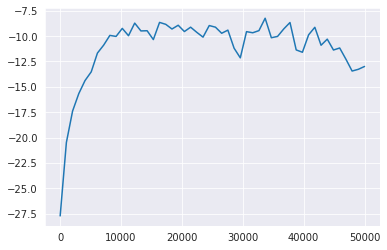

In [ ]:
print("the whole process time is:", t0_lstm_7)
print("the end reward is:", reward0_lstm_7[-1])
reward_plot(reward0_lstm_7)

[-41.58, -30.41, -19.99, -15.92, -17.3, -13.32, -12.11, -10.02, -11.65, -8.49, -8.59, -8.1, -8.27, -7.76, -8.11, -7.18, -8.82, -8.35, -7.32, -8.27, -7.86, -7.54, -8.77, -7.54, -7.84, -7.64, -7.82, -7.58, -7.77, -7.71, -7.71, -7.38, -7.21, -7.45, -7.82, -7.41, -7.3, -7.7, -7.6, -7.59, -7.77, -7.89, -7.71, -8.0, -7.48, -7.45, -7.83, -7.65, -7.56, -7.26]


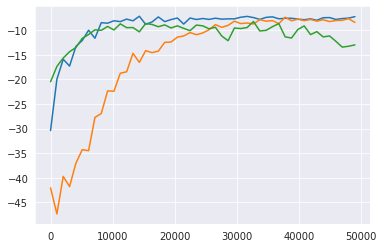

In [ ]:
# the compare in the pomdp problem(7*7)
rewards_pomdp_7 =[]
rewards_pomdp_7.append(reward0_mlp_7_1)
rewards_pomdp_7.append(reward0_mlp_7_2)
rewards_pomdp_7.append(reward0_lstm_7)
print(reward0_mlp_7_1)
reward_plot_all(rewards_pomdp_7)

## test in RNN pomdp (reward function + observation)

In [ ]:
from gridworldRNN import *

In [ ]:
def set_enviroment_rnn(n_width, n_height,flag=True):
    
    if flag== True:
        env =  GridWorldEnvRnn(n_width=n_width, n_height=n_height, u_size=60, default_type=0,
                             max_episode_steps=150, default_reward=-1)
        
    else:
      env = GridWorldEnvRnnNew(n_width=n_width, n_height=n_height, u_size=60, default_type=0,
                             max_episode_steps=100, default_reward=-1,num_obs=4)
   
 
    env.start= (2,2)
    env.end= (5,5)
  
    env.refresh_setting()
    check_env(env)
    return env

In [ ]:
env_pomdp_7_mlp_1 = set_enviroment_rnn(n_width=7, n_height=7,flag=True)
model_pomdp_7_mlp_1 = PPO2('MlpPolicy', env_pomdp_7_mlp_1,verbose=0)

In [ ]:
env_pomdp_7_mlp_2 = set_enviroment_rnn(n_width=7, n_height=7,flag=True)
model_pomdp_7_mlp_2 = PPO2('MlpPolicy', env_pomdp_7_mlp_2, nminibatches=1,
                 lam=0.95, gamma=0.99, noptepochs=4, ent_coef=.01,
                 learning_rate=lambda f: f * 2.5e-4, cliprange=lambda f: f * 0.1, verbose=0)

In [ ]:
env_pomdp_7_lstm = set_enviroment_rnn(n_width=7, n_height=7,flag=True)
model_pomdp_7_lstm = PPO2(CustomLSTMPolicy,env_pomdp_7_lstm, nminibatches=1,
                 lam=0.95, gamma=0.99, noptepochs=4, ent_coef=.01,
                 learning_rate=lambda f: f * 2.5e-4, cliprange=lambda f: f * 0.1, verbose=0)

/usr/local/lib/python3.6/dist-packages/stable_baselines/common/policies.py:437: UserWarning: The new net_arch parameter overrides the deprecated layers parameter.
  warnings.warn("The new net_arch parameter overrides the deprecated layers parameter.")


In [ ]:
reward_pomdp_7_1, t0_pomdp_7_1=train_plot(model_pomdp_7_mlp_1,num=5)

the process time is: 23.559165000915527
-3.1433332
the process time is: 15.475641965866089
-2.6366665
the process time is: 15.422791719436646
-2.6066666
the process time is: 14.996995210647583
-2.5683331
the process time is: 15.048539638519287
-2.6116667


the whole process time is: 84.50313353538513
the end reward is: -2.6116667


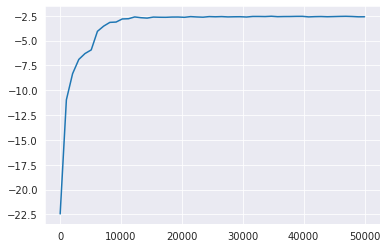

In [ ]:
print("the whole process time is:", t0_pomdp_7_1)
print("the end reward is:", reward_pomdp_7_1[-1])
reward_plot(reward_pomdp_7_1)

In [ ]:
# mlp2
reward_pomdp_7_2, t0_pomdp_7_2=train_plot(model_pomdp_7_mlp_2,num=5)

the process time is: 36.105674028396606
-8.703334
the process time is: 21.09852433204651
-4.9199996
the process time is: 15.71672534942627
-3.0983331
the process time is: 14.093114137649536
-2.69
the process time is: 13.614176988601685
-2.64


the whole process time is: 100.6282148361206
the end reward is: -2.64


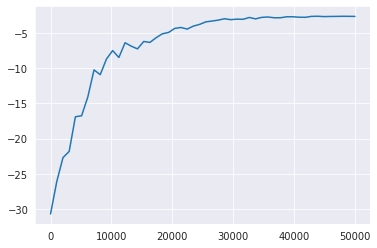

In [ ]:
print("the whole process time is:", t0_pomdp_7_2)
print("the end reward is:", reward_pomdp_7_2[-1])
reward_plot(reward_pomdp_7_2)

In [ ]:
# lstm
reward_pomdp_lstm_7, t0_pomdp_lstm_7=train_plot(model_pomdp_7_lstm,num=5)

the process time is: 89.9852888584137
-6.136667
the process time is: 62.41187334060669
-6.228333
the process time is: 62.295300006866455
-7.36
the process time is: 61.62565732002258
-4.3783336
the process time is: 58.4370813369751
-4.133333


the whole process time is: 334.7552008628845
the end reward is: -4.133333


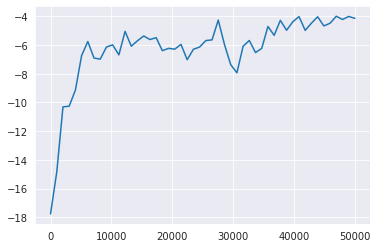

In [ ]:
print("the whole process time is:", t0_pomdp_lstm_7)
print("the end reward is:", reward_pomdp_lstm_7[-1])
reward_plot(reward_pomdp_lstm_7)

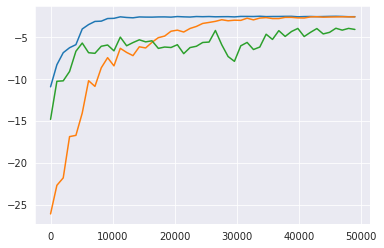

In [ ]:
# compare of three policies in POMDP(7*7)
reward_pomdp_rnn=[]
reward_pomdp_rnn.append(reward_pomdp_7_1)
reward_pomdp_rnn.append(reward_pomdp_7_2)
reward_pomdp_rnn.append(reward_pomdp_lstm_7)
reward_plot_all(reward_pomdp_rnn)

## check if the lstm policy could converge in POMDP(7*7)

In [ ]:
reward_pomdp_lstm_7_2, t0_pomdp_lstm_7_2=train_plot(model_pomdp_7_lstm,num=5)

the process time is: 57.61148405075073
-3.795
the process time is: 59.16426920890808
-3.88
the process time is: 64.80088233947754
-7.861666
the process time is: 62.83374619483948
-6.578333
the process time is: 62.6498908996582
-5.3883333


In [ ]:
reward_pomdp_lstm_7+=reward_pomdp_lstm_7_2
t0_pomdp_lstm_7+=t0_pomdp_lstm_7_2

-3.733333


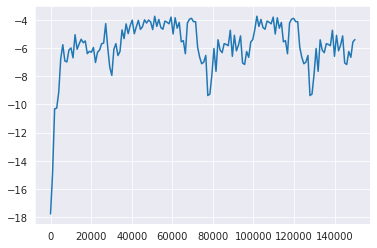

In [ ]:
reward_plot(reward_pomdp_lstm_7)
print(max(reward_pomdp_lstm_7))

## Test in RNN environments(7*7)
### The first RNN enviroment

In [ ]:
env_pomdp_7_mlp_rnn = set_enviroment_rnn(n_width=7, n_height=7,flag=False)
model_pomdp_7_mlp_rnn = PPO2('MlpPolicy', env_pomdp_7_mlp_1,verbose=0)

In [ ]:
reward_pomdp_7_rnn, t0_pomdp_7_rnn=train_plot(model_pomdp_7_mlp_rnn,num=5)

the process time is: 24.147308588027954
-2.8166666
the process time is: 15.591444492340088
-2.583333
the process time is: 15.394299268722534
-2.61
the process time is: 15.207283735275269
-2.5883331
the process time is: 15.097063064575195
-2.625


the whole process time is: 85.43739914894104
the end reward is: -2.625


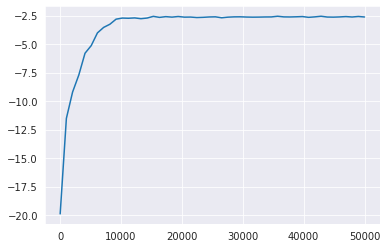

In [ ]:
print("the whole process time is:", t0_pomdp_7_rnn)
print("the end reward is:", reward_pomdp_7_rnn[-1])
reward_plot(reward_pomdp_7_rnn)

## The compare between orignal and new RNN envrioments(POMDP)
### The original default reward is -1; the goal reward is 0 

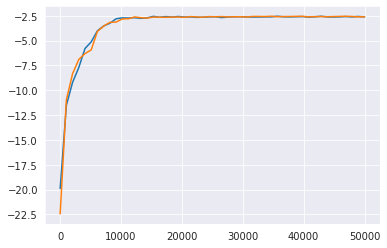

In [ ]:
reward_plot_two(reward_pomdp_7_rnn,reward_pomdp_7_1)

In [ ]:
env_pomdp_7_mlp_rnn2 = set_enviroment_rnn(n_width=7, n_height=7,flag=False)
model_pomdp_7_mlp_rnn2 = PPO2('MlpPolicy', env_pomdp_7_mlp_rnn2, nminibatches=1,
                 lam=0.95, gamma=0.99, noptepochs=4, ent_coef=.01,
                 learning_rate=lambda f: f * 2.5e-4, cliprange=lambda f: f * 0.1, verbose=0)

In [ ]:
reward_pomdp_7_rnn2, t0_pomdp_7_rnn2 = train_plot(model_pomdp_7_mlp_rnn2,num=5)

the process time is: 34.32302498817444
-7.8033338
the process time is: 20.0139741897583
-3.9549997
the process time is: 16.028141498565674
-3.04
the process time is: 14.805402040481567
-2.7033331
the process time is: 14.391900777816772
-2.56


the whole process time is: 99.56244349479675
the end reward is: -2.56


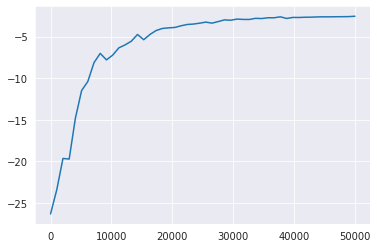

In [ ]:
print("the whole process time is:", t0_pomdp_7_rnn2)
print("the end reward is:", reward_pomdp_7_rnn2[-1])
reward_plot(reward_pomdp_7_rnn2)

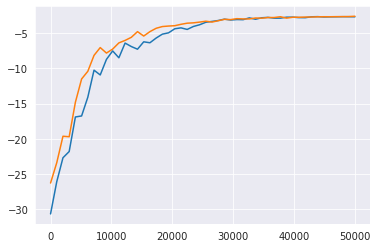

In [ ]:
reward_plot_two(reward_pomdp_7_2, reward_pomdp_7_rnn2)

In [ ]:
## test in 10*10 Grids POMDP problem
# original POMDP enviroment


In [ ]:
# mlp(default parameters) in pomdp
env0_10_mlp_1 = set_enviroment_one(n_width=10, n_height=10,flag=True)
model0_10_mlp_1 = PPO2('MlpPolicy',env0_10_mlp_1,verbose=0)

In [ ]:
# mlp(same parameters as lstm) in pomdp
env0_10_mlp_2 = set_enviroment_one(n_width=10, n_height=10,flag=True)
model0_10_mlp_2 = PPO2('MlpPolicy', env0_10_mlp_2, nminibatches=1,
                 lam=0.95, gamma=0.99, noptepochs=4, ent_coef=.01,
                 learning_rate=lambda f: f * 2.5e-4, cliprange=lambda f: f * 0.1, verbose=0)

In [ ]:
env0_10_lstm = set_enviroment_one(n_width=10, n_height=10,flag=True)
model0_10_lstm = PPO2(CustomLSTMPolicy, env0_10_lstm, nminibatches=1,
                 lam=0.95, gamma=0.99, noptepochs=4, ent_coef=.01,
                 learning_rate=lambda f: f * 2.5e-4, cliprange=lambda f: f * 0.1, verbose=0)

In [ ]:
reward0_mlp_10_1, t0_mlp_10_1=train_plot(model0_10_mlp_1,num=10)

the process time is: 56.48111820220947
-60.28
the process time is: 56.20815110206604
-62.9
the process time is: 55.99544835090637
-60.33
the process time is: 55.03325533866882
-58.1
the process time is: 52.892600774765015
-45.8
the process time is: 54.60845232009888
-52.88
the process time is: 52.519445180892944
-62.46
the process time is: 50.55037260055542
-51.58
the process time is: 51.094855070114136
-45.46
the process time is: 48.03505873680115
-42.34


the whole process time is: 533.4187576770782
the end reward is: -42.34


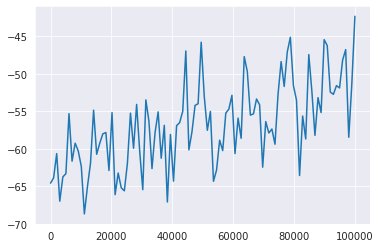

In [ ]:
print("the whole process time is:", t0_mlp_10_1)
print("the end reward is:", reward0_mlp_10_1[-1])
reward_plot(reward0_mlp_10_1)

In [ ]:
reward0_mlp_10_2, t0_mlp_10_2=train_plot(model0_10_mlp_2,num=10)

the process time is: 56.08624339103699
-61.76
the process time is: 55.74098205566406
-57.24
the process time is: 53.58921432495117
-65.1
the process time is: 52.6819212436676
-62.49
the process time is: 52.91023015975952
-57.73
the process time is: 54.28150200843811
-49.99
the process time is: 54.688350439071655
-58.7
the process time is: 52.817219972610474
-65.35
the process time is: 53.49600601196289
-58.98
the process time is: 55.95945382118225
-63.43


the whole process time is: 542.2511234283447
the end reward is: -63.43


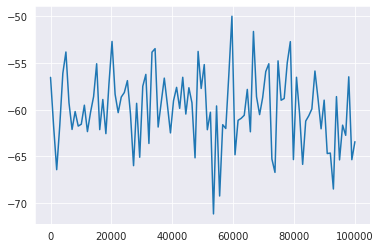

In [ ]:
print("the whole process time is:", t0_mlp_10_2)
print("the end reward is:", reward0_mlp_10_2[-1])
reward_plot(reward0_mlp_10_2)

In [ ]:
reward0_lstm_10, t0_lstm_10=train_plot(model0_10_lstm,num=10)

the process time is: 151.86401510238647
-78.23
the process time is: 129.53094792366028
-80.94
the process time is: 128.4835169315338
-80.15
the process time is: 126.98293256759644
-70.5
the process time is: 121.01631426811218
-70.91
the process time is: 109.82137680053711
-62.68
the process time is: 118.29804611206055
-85.54
the process time is: 136.91517972946167
-88.63
the process time is: 129.4418420791626
-59.14
the process time is: 114.2160279750824
-78.77


the whole process time is: 1266.5701994895935
the end reward is: -78.77


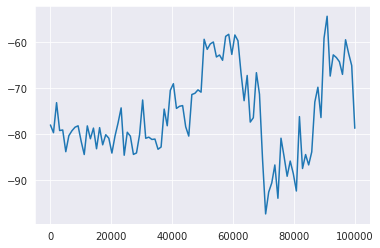

In [ ]:
print("the whole process time is:", t0_lstm_10)
print("the end reward is:", reward0_lstm_10[-1])
reward_plot(reward0_lstm_10)

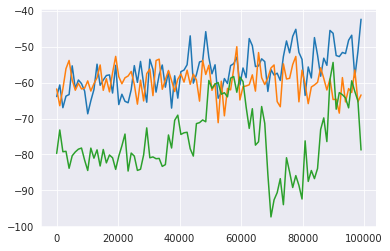

In [ ]:
rewards_pomdp_10=[]
rewards_pomdp_10.append(reward0_mlp_10_1)
rewards_pomdp_10.append(reward0_mlp_10_2)
rewards_pomdp_10.append(reward0_lstm_10)
reward_plot_all(rewards_pomdp_10)

In [ ]:
## test in RNN model (reward function + observation)


In [ ]:
env_pomdp_10_mlp_1 = set_enviroment_rnn(n_width=10, n_height=10,flag=True)
model_pomdp_10_mlp_1 = PPO2('MlpPolicy', env_pomdp_10_mlp_1,verbose=0)

In [ ]:
env_pomdp_10_mlp_2 = set_enviroment_rnn(n_width=10, n_height=10,flag=True)
model_pomdp_10_mlp_2 = PPO2('MlpPolicy', env_pomdp_10_mlp_2, nminibatches=1,
                 lam=0.95, gamma=0.99, noptepochs=4, ent_coef=.01,
                 learning_rate=lambda f: f * 2.5e-4, cliprange=lambda f: f * 0.1, verbose=0)

In [ ]:
env_pomdp_10_lstm = set_enviroment_rnn(n_width=10, n_height=10,flag=True)
model_pomdp_10_lstm = PPO2(CustomLSTMPolicy,env_pomdp_10_lstm, nminibatches=1,
                 lam=0.95, gamma=0.99, noptepochs=4, ent_coef=.01,
                 learning_rate=lambda f: f * 2.5e-4, cliprange=lambda f: f * 0.1, verbose=0)

/usr/local/lib/python3.6/dist-packages/stable_baselines/common/policies.py:437: UserWarning: The new net_arch parameter overrides the deprecated layers parameter.
  warnings.warn("The new net_arch parameter overrides the deprecated layers parameter.")


In [ ]:
reward_mlp_10_1, t_mlp_10_1=train_plot(model_pomdp_10_mlp_1,num=10)

the process time is: 71.67327857017517
-37.04375
the process time is: 66.34193682670593
-38.55
the process time is: 64.80168175697327
-32.46
the process time is: 61.76645016670227
-26.4075
the process time is: 59.75985050201416
-27.23625
the process time is: 55.98673057556152
-21.22375
the process time is: 55.67530965805054
-21.92125
the process time is: 52.05659747123718
-21.89
the process time is: 51.36607837677002
-21.01
the process time is: 49.477553844451904
-18.25875


the whole process time is: 588.905467748642
the end reward is: -18.25875


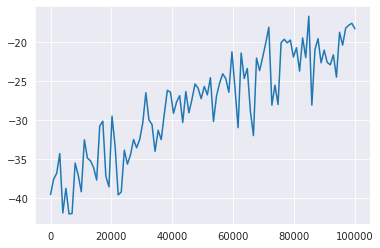

In [ ]:
print("the whole process time is:", t_mlp_10_1)
print("the end reward is:", reward_mlp_10_1[-1])
reward_plot(reward_mlp_10_1)

In [ ]:
reward_mlp_10_2, t_mlp_10_2=train_plot(model_pomdp_10_mlp_2,num=10)

the process time is: 68.65574789047241
-45.895
the process time is: 69.07729315757751
-41.51625
the process time is: 68.00939130783081
-38.4225
the process time is: 71.1300847530365
-34.45
the process time is: 66.46138119697571
-38.77625
the process time is: 66.38472962379456
-34.815
the process time is: 65.39959049224854
-37.78625
the process time is: 62.38255953788757
-36.38625
the process time is: 61.35975742340088
-31.49625
the process time is: 60.86946964263916
-33.76875


the whole process time is: 659.7300050258636
the end reward is: -33.76875


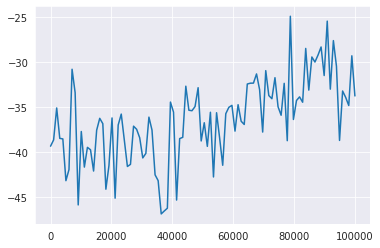

In [ ]:
print("the whole process time is:", t_mlp_10_2)
print("the end reward is:", reward_mlp_10_2[-1])
reward_plot(reward_mlp_10_2)

In [ ]:
reward_lstm_10, t_lstm_10=train_plot(model_pomdp_10_lstm,num=10)

the process time is: 150.40086889266968
-38.265
the process time is: 120.12668657302856
-29.58375
the process time is: 122.52929520606995
-44.77875
the process time is: 127.87026143074036
-51.64375
the process time is: 128.26228189468384
-56.865
the process time is: 122.34910249710083
-49.0675
the process time is: 111.58950424194336
-46.7
the process time is: 102.6777036190033
-29.0425
the process time is: 109.6232259273529
-38.6725
the process time is: 109.02000379562378
-41.85125


the whole process time is: 1204.4489340782166
the end reward is: -41.85125


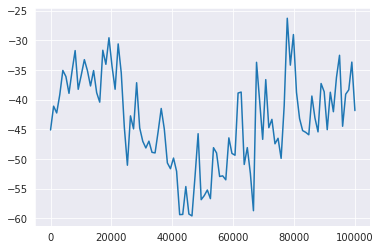

In [ ]:
print("the whole process time is:", t_lstm_10)
print("the end reward is:", reward_lstm_10[-1])
reward_plot(reward_lstm_10)

In [ ]:
print(reward_mlp_10_2)
print(reward_mlp_10_1)

[-39.36, -38.66125, -35.10375, -38.48625, -38.55, -43.1975, -41.95875, -30.7975, -33.40375, -45.895, -37.725, -41.685, -39.4875, -39.7575, -42.12375, -37.57875, -36.2575, -36.8525, -44.145, -41.51625, -36.2175, -45.14375, -37.00375, -35.78625, -38.6875, -41.61625, -41.38125, -37.13125, -37.4775, -38.4225, -40.6625, -40.16125, -36.125, -37.56375, -42.54625, -43.19, -46.895, -46.56625, -46.26125, -34.45, -35.5725, -45.35375, -38.51375, -38.37375, -32.6825, -35.35875, -35.41125, -34.95, -32.85, -38.77625, -36.75, -39.3775, -35.58375, -42.7825, -35.635, -38.4525, -41.4825, -35.74375, -35.03375, -34.815, -37.68125, -34.74125, -36.58125, -36.94125, -32.44, -32.34875, -32.33875, -31.31875, -33.06875, -37.78625, -30.9525, -33.725, -34.075, -31.73625, -34.96875, -35.915, -32.36375, -38.7475, -24.89875, -36.38625, -34.27375, -33.8725, -34.4675, -28.48125, -33.12, -29.43125, -29.99375, -29.22125, -28.31875, -31.49625, -25.44125, -33.01125, -27.61, -30.46375, -38.71875, -33.2175, -33.93, -34.83125

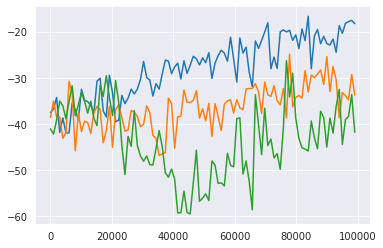

In [ ]:
rewards_pomdp_10_rnn=[]
rewards_pomdp_10_rnn.append(reward_mlp_10_1)
rewards_pomdp_10_rnn.append(reward_mlp_10_2)
rewards_pomdp_10_rnn.append(reward_lstm_10)
reward_plot_all(rewards_pomdp_10_rnn)

In [ ]:
env_pomdp_10_mlp_1_rnn = set_enviroment_rnn(n_width=10, n_height=10,flag=False)
model_pomdp_10_mlp_1_rnn = PPO2('MlpPolicy', env_pomdp_10_mlp_1_rnn,verbose=0)

In [ ]:
env_pomdp_10_mlp_2_rnn = set_enviroment_rnn(n_width=10, n_height=10,flag=False)
model_pomdp_10_mlp_2_rnn = PPO2('MlpPolicy', env_pomdp_10_mlp_2, nminibatches=1,
                 lam=0.95, gamma=0.99, noptepochs=4, ent_coef=.01,
                 learning_rate=lambda f: f * 2.5e-4, cliprange=lambda f: f * 0.1, verbose=0)

In [ ]:
reward_mlp_10_1_rnn, t_mlp_10_1_rnn=train_plot(model_pomdp_10_mlp_1_rnn,num=10)

the process time is: 62.26398038864136
-28.1875
the process time is: 50.84434747695923
-22.79
the process time is: 27.257083892822266
-2.33
the process time is: 15.682933807373047
-2.2975
the process time is: 15.347673892974854
-1.875
the process time is: 15.402138233184814
-1.875
the process time is: 15.46169137954712
-1.875
the process time is: 15.395000457763672
-1.875
the process time is: 15.386048793792725
-1.87875
the process time is: 15.350576162338257
-1.875


the whole process time is: 248.39147448539734
the end reward is: -1.875


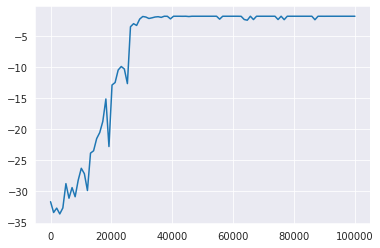

In [ ]:
print("the whole process time is:", t_mlp_10_1_rnn)
print("the end reward is:", reward_mlp_10_1_rnn[-1])
reward_plot(reward_mlp_10_1_rnn)

In [ ]:
reward_mlp_10_2_rnn, t_mlp_10_2_rnn=train_plot(model_pomdp_10_mlp_2_rnn,num=10)

the process time is: 69.96394157409668
-39.68375
the process time is: 71.40303635597229
-38.69875
the process time is: 69.37961721420288
-39.095
the process time is: 67.14561200141907
-32.70375
the process time is: 66.19797706604004
-37.13125
the process time is: 67.66617131233215
-29.74
the process time is: 61.41841149330139
-33.1425
the process time is: 60.73097562789917
-30.0
the process time is: 62.343103885650635
-33.4475
the process time is: 58.282076835632324
-26.20125


the whole process time is: 654.5309233665466
the end reward is: -26.20125


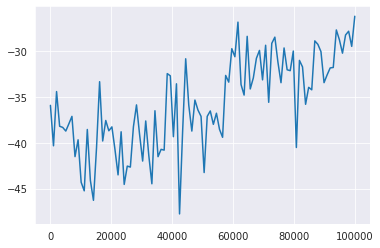

In [ ]:
print("the whole process time is:", t_mlp_10_2_rnn)
print("the end reward is:", reward_mlp_10_2_rnn[-1])
reward_plot(reward_mlp_10_2_rnn)

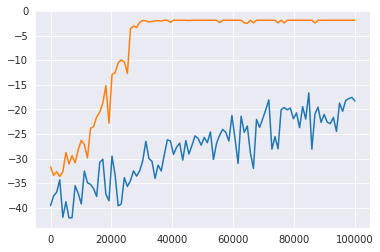

In [ ]:
reward_plot_two(reward_mlp_10_1,reward_mlp_10_1_rnn)
print(rewar)

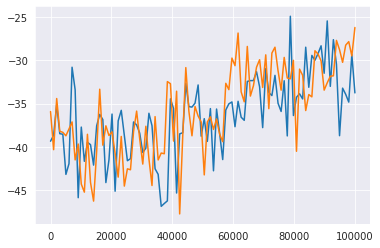

In [ ]:
reward_plot_two(reward_mlp_10_2,reward_mlp_10_2_rnn)